<h1>Project: Fundamentals of Information Systems </h1>

<h3>Introduction</h3>

This data has been gathered at **two solar power plants** in India over a **34 day** period. It has **two** pairs of files - each pair has **one power generation dataset** and **one sensor readings dataset**. 
- The **power generation datasets** are gathered at the inverter level - each inverter has multiple lines of solar panels attached to it. 
- The **sensor data** is gathered at a plant level - a single array of sensors optimally placed at the plant.

# Output

**Questions:**
 - What is the **mean** value of **daily yield**? 
 - What is the **total irradiation per day**? 
 - What is the **max ambient** and **module temperature**? 
 - **How many inverters** are there **for each plant**? 
 - What is the **maximum/minimum amount** of **DC/AC Power generated** in a **time interval/day**? 
 - **Which inverter** (source_key) has produced **maximum DC/AC power**? 
 - **Rank the inverters** based on the **DC/AC power** they produce? Is there **any missing data**?
 
 
 - Graphs that explain the patterns for attributes independent of other variables. These will usually be tracked as changes of attributes against DATETIME, DATE, or TIME. 
**Examples.** How is DC or AC Power changing as time goes by? how is irradiation changing as time goes by? how are ambient and module temperature changing as time goes by? how does yield change as time goes by? Explore plotting variables against different granularities of DATETIME and which is the best option for each variable.

#  Variables

**Power generation data**
- DATE_TIME: Date and time for each observation. Observations recorded at 15 minute intervals.
 
- PLANT_ID: Plant ID - this will be common for the entire file.
 
- SOURCE_KEY: Source key in this file stands for the inverter id.
 
- DC_POWER: Amount of DC power generated by the inverter (source_key) in this 15 minute interval. Units - kW.
 
- AC_POWER: Amount of AC power generated by the inverter (source_key) in this 15 minute interval. Units - kW.
 
- DAILY_YIELD: Daily yield is a cumulative sum of power generated on that day, till that point in time.
 
- TOTAL_YIELD: This is the total yield for the inverter till that point in time.
 
**Weather sensor data**
 - DATE_TIME: Date and time for each observation. Observations recorded at 15 minute intervals.
 
 - PLANT_ID: Plant ID - this will be common for the entire file.
 
 - SOURCE_KEY: Stands for the sensor panel id. This will be common for the entire file because there's only one sensor panel for the plant.
 
 - AMBIENT_TEMPERATURE: This is the ambient temperature at the plant.
 
 - MODULE_TEMPERATURE: There's a module (solar panel) attached to the sensor panel. This is the temperature reading for that module.
 
 - IRRADIATION: Amount of irradiation for the 15 minute interval.



<h5>Libraries needed</h5>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime

**Data**

In [5]:
p1_gen = pd.read_csv('Plant_1_Generation_data.csv')
p1_wea = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')
p2_gen = pd.read_csv("Plant_2_Generation_data.csv") 
p2_wea = pd.read_csv("Plant_2_Weather_Sensor_Data.csv")

In [6]:
print("Shape of the table for plant 1 generation data: ", p1_gen.shape)
print("Shape of the table for plant 2 generation data: ",p2_gen.shape)
print("Name of the columns for the dataframes: \n",list(p1_gen.columns))
assert(np.all(p1_gen.columns == p2_gen.columns))  # just making sure they have the same columns

Shape of the table for plant 1 generation data:  (68778, 7)
Shape of the table for plant 2 generation data:  (67698, 7)
Name of the columns for the dataframes: 
 ['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']


In [7]:
print("Shape of the table for weather sensor plant 1: ", p1_wea.shape)
print("Shape of the table for weather sensor plant 2: ", p2_wea.shape)
print("Column names for weather sensor tables: \n", list(p1_wea.columns))
assert(np.all(p1_wea.columns == p2_wea.columns)) # just making sure they have the same columns

Shape of the table for weather sensor plant 1:  (3182, 6)
Shape of the table for weather sensor plant 2:  (3259, 6)
Column names for weather sensor tables: 
 ['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']


<h3> DATA PREPARATION </h3>

The format of the dates in the DATE_TIME column is different between df p1_gen and p2_gen;
If we want to join them it's better to convert to the same format

In [8]:
def convert_dates(date):
    return date[8:10]+date[4:8]+date[:4]+date[10:-3]

p2_gen.DATE_TIME = p2_gen.DATE_TIME.apply(convert_dates)

we concatenate the two dataframes regarding the inverters


In [9]:
panels = pd.concat([p1_gen,p2_gen])

Grouping by day is going to be much easier for the computations we'll have to do.
We create a day column for the inverters dataframe, which ignores the hour of the relevation.

In [10]:
panels["DAY"] = panels.DATE_TIME.apply(lambda x: datetime.datetime.strptime(x,"%d-%m-%Y %H:%M").date())

assert(panels.shape == (p1_gen.shape[0]+p2_gen.shape[0],p1_gen.shape[1]+1)) # just to check dimensions are fine after the merge
panels.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DAY
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,2020-05-15
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,2020-05-15
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,2020-05-15
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,2020-05-15
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,2020-05-15


We do the same for the sensors, concatenating the two dataframes and creating a new column for the day

In [11]:
sensors = pd.concat([p1_wea,p2_wea])
sensors["DAY"] = sensors.DATE_TIME.apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").date())

assert(sensors.shape == (p1_wea.shape[0]+p2_wea.shape[0],p1_wea.shape[1]+1)) # just to check dimensions are fine after the merge
sensors.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,2020-05-15
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0,2020-05-15
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0,2020-05-15
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0,2020-05-15
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0,2020-05-15


<h3> QUESTIONS </h3>

<h4>1) What is the mean value of daily yield?</h4>

We're going to calculate:
 - the average daily yield for a single inverter
 - the total daily yield considering all (active) inverters

<h5> 1.1) Average daily yield for a single inverter </h5>

The daily yield is cumulative and gets resetted at midnight for every inverter (see graph below for an example)

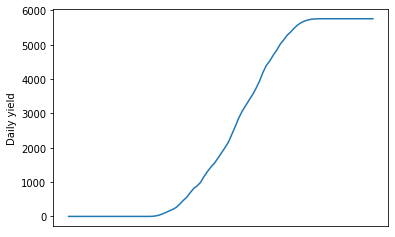

In [92]:
panels[(panels["SOURCE_KEY"] == "1BY6WEcLGh8j5v7")&(panels.DAY == datetime.date(2020, 5, 15))]["DAILY_YIELD"].plot()
plt.ylabel("Daily yield")
plt.xlabel("")
plt.xticks([])
plt.show()

Knowing that, we group by inverter ID and day: considering the maximum per day we're basically choosing the last daily_yield relevation per day per source

In [31]:
grouped_df = panels.DAILY_YIELD.groupby([panels.SOURCE_KEY,panels.DAY]).max().reset_index()

In [32]:
grouped_df.head()

,SOURCE_KEY,DAY,DAILY_YIELD
0,1BY6WEcLGh8j5v7,2020-05-15,5754.0
1,1BY6WEcLGh8j5v7,2020-05-16,6292.0
2,1BY6WEcLGh8j5v7,2020-05-17,7045.0
3,1BY6WEcLGh8j5v7,2020-05-18,4998.0
4,1BY6WEcLGh8j5v7,2020-05-19,6449.0


<h6>   missing data</h6>

We can check now if there is data for every inverter for every day:

In [56]:
grouped_df.DAY.groupby(grouped_df.SOURCE_KEY).count().reset_index().DAY.value_counts()

34    40
26     4
Name: DAY, dtype: int64

It looks like for 4 inverters out of 44 only 26 days of data are provided.
For the other 40 inverters 34 day of data were provided.
We can easily figure out for which days this happened:

In [70]:
grouped_df.SOURCE_KEY.groupby(grouped_df.DAY).count()

DAY
2020-05-15    44
2020-05-16    44
2020-05-17    44
2020-05-18    44
2020-05-19    44
2020-05-20    44
2020-05-21    40
2020-05-22    40
2020-05-23    40
2020-05-24    40
2020-05-25    40
2020-05-26    40
2020-05-27    40
2020-05-28    40
2020-05-29    44
2020-05-30    44
2020-05-31    44
2020-06-01    44
2020-06-02    44
2020-06-03    44
2020-06-04    44
2020-06-05    44
2020-06-06    44
2020-06-07    44
2020-06-08    44
2020-06-09    44
2020-06-10    44
2020-06-11    44
2020-06-12    44
2020-06-13    44
2020-06-14    44
2020-06-15    44
2020-06-16    44
2020-06-17    44
Name: SOURCE_KEY, dtype: int64

Between 21-05-2020 and 28-05-2020 (so for 8 days as expected) we don't have data for 4 inverters.
We can still calculate the average for the single inverters but we need to keep in mind this.


We now consider the mean daily_yield per source_key (per inverter) and plot the distribution as an histogram

In [71]:
mean_yields_per_inverter = grouped_df.DAILY_YIELD.groupby(grouped_df.SOURCE_KEY).mean().reset_index()

In [72]:
mean_yields_per_inverter.head()

,SOURCE_KEY,DAILY_YIELD
0,1BY6WEcLGh8j5v7,6639.865546
1,1IF53ai7Xc0U56Y,7348.806373
2,3PZuoBAID5Wc2HD,7341.279412
3,4UPUqMRk7TRMgml,7703.903782
4,7JYdWkrLSPkdwr4,7172.323529


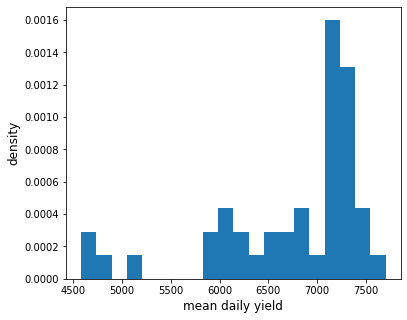

In [64]:
plt.figure(figsize=(6,5))
plt.hist(mean_yields_per_inverter.DAILY_YIELD,density=True,bins=20)
plt.xlabel("mean daily yield",fontsize=12)
plt.ylabel("density",fontsize=12)
plt.show()

Finally we calculate the mean of the distribution:

In [65]:
mean_inverter_daily_yield = mean_yields_per_inverter.DAILY_YIELD.mean()

In [69]:
print(f"The average daily yield for a single inverter,\
 calculated considering all panels, is {round(mean_inverter_daily_yield,2)} kW/day.")

The average daily yield for a single inverter, calculated considering all panels, is 6743.89 kW/day.


<h5> 1.2) Average total daily yield </h5>

We can instead compute the total daily yield considering every inverter and grouping by day

In [39]:
total_daily_yields = grouped_df.DAILY_YIELD.groupby(grouped_df.DAY).sum().reset_index()

In [40]:
total_daily_yields.head()

,DAY,DAILY_YIELD
0,2020-05-15,306829.000000
1,2020-05-16,289470.933333
2,2020-05-17,304520.000000
3,2020-05-18,249897.000000
4,2020-05-19,266590.125000


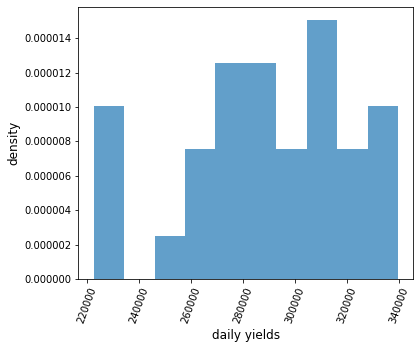

In [73]:
# let's plot the distribution for total daily yield

plt.figure(figsize=(6,5))
plt.hist(total_daily_yields.DAILY_YIELD,density=True,bins=10,alpha=0.7)
plt.xlabel("daily yields",fontsize=12)
plt.ylabel("density",fontsize=12)
plt.xticks(rotation=70)
plt.show()

We've seen before that for 8 days we didn't have data for some inverters (between 21 and 28 of may), we can now see  where these days are within the distribution.

In [75]:
missing_data_days = [datetime.date(2020,5,i) for i in range(21,29,1)]

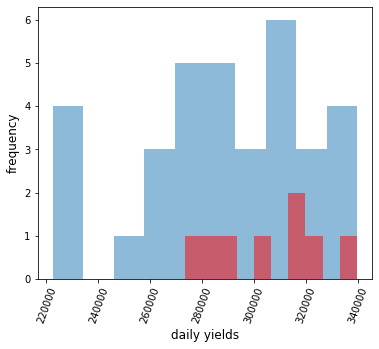

In [96]:
# let's plot the frequencies keeping track of the days for which we miss some data this time

plt.figure(figsize=(6,5))
plt.hist(total_daily_yields.DAILY_YIELD,bins=10,alpha=0.5)
plt.hist(total_daily_yields[total_daily_yields.DAY.isin(missing_data_days)].DAILY_YIELD,alpha=0.5,color="red")
plt.xlabel("daily yields",fontsize=12)
plt.ylabel("frequency",fontsize=12)
plt.xticks(rotation=70)
plt.show()

Contrarily to what could be thought for the days we're missing data the daily yields are actually quite high!

This may be due to different solar irradiation through the days? We'll explore this in the next question

We can finally calculate the average total daily yield:

In [42]:
mean_total_daily_yield = total_daily_yields.DAILY_YIELD.mean()
print(f"Mean total daily yield is {round(mean_total_daily_yield,2)} kW/day.")

Mean total daily yield is 290010.72 kW/day.


<h4>2) What is the total irradiation per day?</h4>

In [25]:
sensors.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,2020-05-15
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0,2020-05-15
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0,2020-05-15
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0,2020-05-15
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0,2020-05-15


Differently from what we've seen for the daily yield, irradiation isn't a cumulative measure through the day, as we can see from the example below.

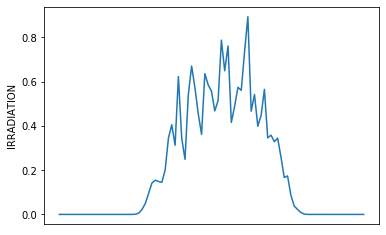

In [100]:
sensors[(sensors.SOURCE_KEY == "HmiyD2TTLFNqkNe")&(sensors.DAY == datetime.date(2020,5,15))]["IRRADIATION"].plot()
plt.ylabel("IRRADIATION")
plt.xticks([])
plt.show()

Since it isn't cumulative we can group everything by day and simply sum up all the values of irradiation for all the sensors:

In [101]:
irr_per_day_df = sensors.IRRADIATION.groupby(sensors.DAY).sum().reset_index()

In [102]:
irr_per_day_df.head()

,DAY,IRRADIATION
0,2020-05-15,47.596065
1,2020-05-16,42.328263
2,2020-05-17,44.164973
3,2020-05-18,36.762265
4,2020-05-19,38.390182


We can now see how irradiation correlates to the total daily yield obtained:

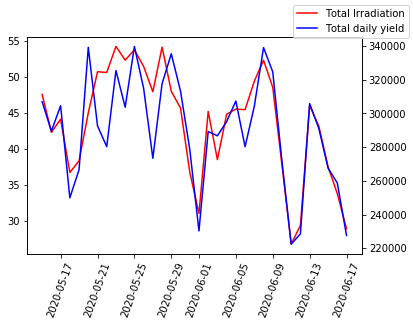

In [103]:
fig,ax = plt.subplots()
plt.xticks(rotation=70)
ax.plot(irr_per_day_df.DAY,irr_per_day_df.IRRADIATION,color="red")
ax2 = ax.twinx()
ax2.plot(total_daily_yields.DAY,total_daily_yields.DAILY_YIELD,color="blue")
fig.legend(["Total Irradiation","Total daily yield"],loc=1)
plt.show()

We observe a descrepancy between 21/05 and 28/05. As reported above this is most likely due to missing data (or maybe the inverters weren't active at all). For those days, in particular, we observe that the total irradiation has been quite high; this justifies the fact that in point 1.2. we observed that the total daily yield was actually on the higher end of the distribution even though less data was present.

To recap we report a table of the total irradiation for all days:

In [105]:
irr_per_day_df

,DAY,IRRADIATION
0,2020-05-15,47.596065
1,2020-05-16,42.328263
2,2020-05-17,44.164973
3,2020-05-18,36.762265
4,2020-05-19,38.390182
5,2020-05-20,45.032413
6,2020-05-21,50.747355
7,2020-05-22,50.654966
8,2020-05-23,54.266632
9,2020-05-24,52.363225


<h4> 3) What is the max ambient and module temperature?</h4>

In [108]:
ambient_temp = sensors.AMBIENT_TEMPERATURE.max()
print("Max ambient temperature:",round(ambient_temp,2))
module_temp = sensors.MODULE_TEMPERATURE.max()
print("Max module temperature:",round(module_temp,2))

Max ambient temperature: 39.18
Max module temperature: 66.64


<h4> 4) How many inverters are there for each plant?</h4>

In [112]:
plant1_inverters = len(p1_gen.SOURCE_KEY.unique())
plant2_inverters = len(p2_gen.SOURCE_KEY.unique())

print(f"There are {plant1_inverters} inverters in plant 1.")
print(f"There are {plant2_inverters} inverters in plant 2.")

There are 22 inverters in plant 1.
There are 22 inverters in plant 2.


<h4> 5) What is the maximum/minimum amount of DC/AC Power generated in a day?</h4>

Just like it was for the irradiation, DC and AC power aren't cumulative measures through the day (as it's clear from the example below)

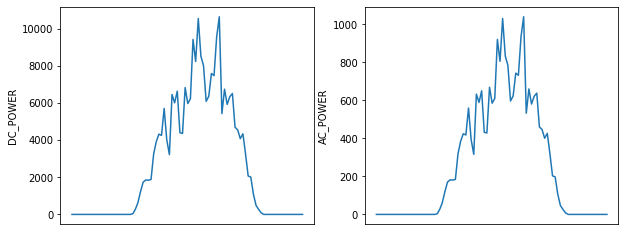

In [121]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
panels[(panels.SOURCE_KEY == "1BY6WEcLGh8j5v7")&(panels.DAY == datetime.date(2020,5,15))].DC_POWER.plot()
plt.ylabel("DC_POWER")
plt.xticks([])
plt.subplot(1,2,2)
panels[(panels.SOURCE_KEY == "1BY6WEcLGh8j5v7")&(panels.DAY == datetime.date(2020,5,15))].AC_POWER.plot()
plt.ylabel("AC_POWER")
plt.xticks([])
plt.show()

Knowing this, we can sum them up considering all inverters through the day. This way we obtain two dataframes reporting the totals per day.

In [123]:
dc_power_per_day = panels.DC_POWER.groupby(panels.DAY).sum().reset_index()
ac_power_per_day = panels.AC_POWER.groupby(panels.DAY).sum().reset_index()

In [124]:
dc_power_per_day.head()

,DAY,DC_POWER
0,2020-05-15,6.293847e+06
1,2020-05-16,6.372977e+06
2,2020-05-17,7.315831e+06
3,2020-05-18,5.343322e+06
4,2020-05-19,5.881451e+06


In [125]:
ac_power_per_day.head()

,DAY,AC_POWER
0,2020-05-15,1.202269e+06
1,2020-05-16,1.122613e+06
2,2020-05-17,1.205368e+06
3,2020-05-18,9.899823e+05
4,2020-05-19,9.658052e+05


And now we can easily calculate the max/min produced in a day:

In [127]:
print(f"Maximum DC POWER per day: {round(max(dc_power_per_day.DC_POWER),2)} kW")
print(f"Minimum DC POWER per day: {round(min(dc_power_per_day.DC_POWER),2)} kW")
print(f"Maximum AC POWER per day: {round(max(ac_power_per_day.AC_POWER),2)} kW")
print(f"Minimum AC POWER per day: {round(min(ac_power_per_day.AC_POWER),2)} kW")

Maximum DC POWER per day: 8481752.45 kW
Minimum DC POWER per day: 5343322.21 kW
Maximum AC POWER per day: 1341152.42 kW
Minimum AC POWER per day: 830022.68 kW


In [39]:
panels.groupby("SOURCE_KEY").DC_POWER.sum().sort_values(ascending=False)

SOURCE_KEY
adLQvlD726eNBSB    1.019778e+07
1IF53ai7Xc0U56Y    1.006294e+07
VHMLBKoKgIrUVDU    1.005725e+07
3PZuoBAID5Wc2HD    1.004313e+07
McdE0feGgRqW7Ca    1.003212e+07
ZnxXDlPa8U1GXgE    9.997405e+06
iCRJl6heRkivqQ3    9.987733e+06
uHbuxQJl8lW7ozc    9.985363e+06
zVJPv84UY57bAof    9.956927e+06
wCURE6d3bPkepu2    9.911622e+06
pkci93gMrogZuBj    9.895623e+06
rGa61gmuvPhdLxV    9.881965e+06
YxYtjZvoooNbGkE    9.869145e+06
WRmjgnKYAwPKWDb    9.838489e+06
sjndEbLyjtCKgGv    9.835197e+06
zBIq5rxdHJRwDNY    9.820452e+06
7JYdWkrLSPkdwr4    9.815350e+06
ZoEaEvLYb1n2sOq    9.803128e+06
z9Y9gH1T5YWrNuG    9.797002e+06
ih0vzX44oOqAx2f    9.695845e+06
1BY6WEcLGh8j5v7    9.063716e+06
bvBOhCH3iADSZry    8.925490e+06
Mx2yZCDsyf6DPfv    9.106173e+05
Qf4GUc1pJu5T6c6    8.905963e+05
4UPUqMRk7TRMgml    8.874449e+05
oZ35aAeoifZaQzV    8.851519e+05
V94E5Ben1TlhnDV    8.543757e+05
vOuJvMaM2sgwLmb    8.541729e+05
oZZkBaNadn6DNKz    8.340470e+05
PeE6FRyGXUgsRhN    8.104788e+05
LlT2YUhhzqhg5Sw    8.000627e+

**....altre domande** (TODO)

<h5>parte grafica</h5> (totalmente da fare, solo un esempio) (TODO)

e.g. how are ambient and module temperature changing as time goes by?

In [35]:
# per esempio per un specifico sensore
first_sensor_df = sensor2[sensor2["SOURCE_KEY"]=="iq8k7ZNt4Mwm3w0"]
first_sensor_df.shape
plt.subplot(2,1,1)
plt.plot(first_sensor_df["DATE_TIME"][::24],first_sensor_df["AMBIENT_TEMPERATURE"][::24])
plt.subplot(2,1,2)
plt.plot(first_sensor_df["DATE_TIME"][::24],first_sensor_df["MODULE_TEMPERATURE"][::24])
plt.show()

NameError: name 'sensor2' is not defined